In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            

import torch
torch.set_printoptions(precision=10)

from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
import yaml
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
from datasets.dataset_utils import  fp_loader_configer, plot_NMR
fp_loader_configer.select_version("DB_Specific")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


DB_Specific_FP_loader is selected


In [3]:
# load model 

# Choice 1: flexible model
# Choice  2: all-three nmr model
model_path = Path(f"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/db_specific_FP_with_entropy/entropy_radius_exps_all_info/R0_to_R2_all_info_trial_2")
checkpoint_path = model_path / "checkpoints/epoch=20-step=10899.ckpt"

hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
print(FP_building_type)

try:
    radius = int(hparams['FP_choice'].split("_")[-1])
except ValueError:
    print("[Main] Cannot find radius in FP_choice, using default radius 10")
    radius = 10
max_radius = radius
print("max_radius: ", max_radius)

fp_loader.setup(out_dim=hparams['out_dim'], max_radius=max_radius)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




Normal
max_radius:  2
finish entropy list
DB_Specific_FP_loader is setup


In [4]:
model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)


/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/dataset_utils.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fragments = torch.load(file

HsqcRankedTransformer saving args


In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")

datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# model=model.to("cuda")
model=model.to("cpu")

In [9]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [10]:
print(len(smiles_and_names))

526316


In [11]:
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/db_specific_FP_max_radius_10_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)
# .to("cuda")
rankingset_data.device

device(type='cpu')

In [27]:
len(rankingset_data)

526316

In [12]:
memory_size = rankingset_data.element_size() * rankingset_data.numel() / (1024 * 1024)
print(f"Memory size of rankingset_data: {memory_size:.2f} MB")

Memory size of rankingset_data: 12335.53 MB


In [13]:
# initialize MFP gnenerator for later fragment visualization
from rdkit.Chem import rdFingerprintGenerator
import inference.inference_utils 

fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=10)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()
index_to_frag_mapping = {v:str(k) for k, v in fp_loader.frag_to_index_map.items()}



In [28]:
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK


############################################### compound number: 3314##############################################################
Ground Truth NMR and structure


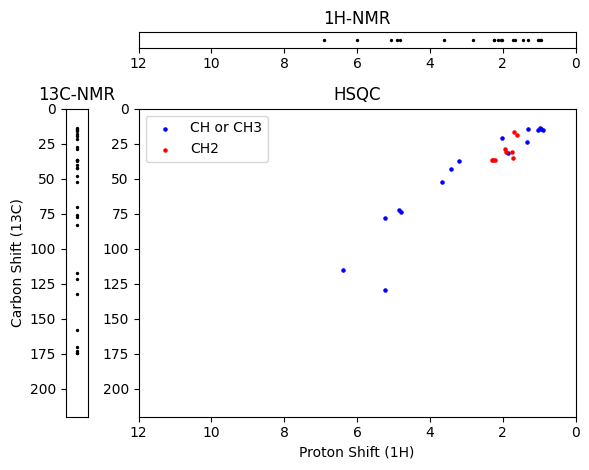

Ground truth chemical name methyl briareolate
Ground truth SMILES CCCC(=O)OC1CC(OC(C)=O)C2(C)C(OC(=O)CCC)CCC3(C)C=CC(C(C)C(=O)OC)=C(O3)C2C1C


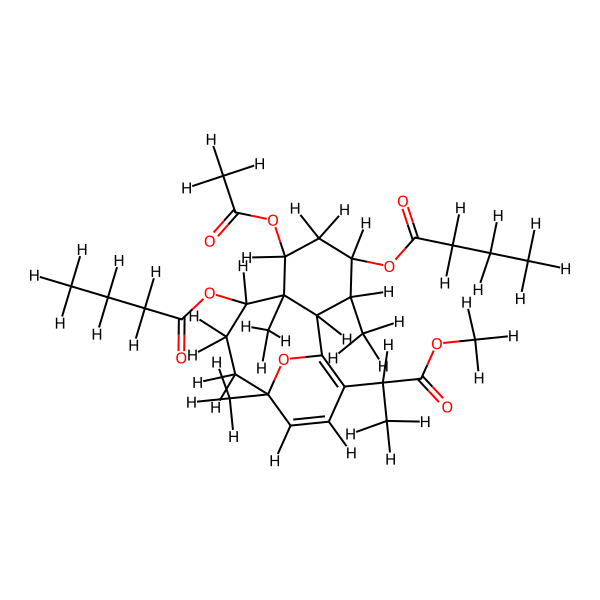

Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.9984642267227173
________retival #1, cosine similarity to prediction: 0.5980864763259888_________________
retrival is the same as ground truth: False
ground truth FP [[0], [1], [3], [4], [5], [6], [7], [8], [9], [12], [14], [15], [18], [19], [25], [30], [35], [66], [67], [79], [87], [88], [98], [113], [114], [148], [173], [253], [341], [646], [747], [876], [2145], [2552]]
retrived FP [0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.0, 0.0, 0.18257418274879456, 0.0, 0.18257418274879456, 0.18257418274879456, 0.0, 0.0, 0.18257418274879456, 0.18257418274879456, 0.18257418274879456, 0.0, 0.0, 0.0, 0.0, 0.18257418274879456, 0.0, 0.0, 0.0, 0.0, 0.18257418274879456, 0.0, 0.0, 0.0, 0.0, 0.18257418274879456, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

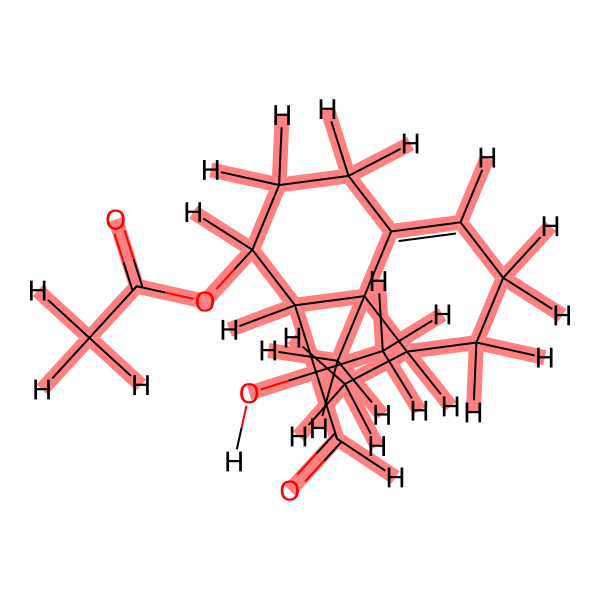

DONE






In [ ]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# model.to("cuda")
# for  which_compound in  random.sample(range(len(loader_all_inputs.dataset)), k=1):# range(0, 1):  
for which_compound in [3313]:    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(loader_all_inputs):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR and structure")
    plot_NMR(hsqc, c_tensor, h_tensor)
    


    # ground truth
    mol = Chem.MolFromSmiles(smiles[0])
    mol = Chem.AddHs(mol)
    print(f"Ground truth chemical name {names[0]}")
    print(f"Ground truth SMILES {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol, size=(600, 600))
    img.show()
    
    ground_truth_FP = fp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Ground truth cosine similarity to prediction(floating point number after sigmoid): ", compute_cos_sim(ground_truth_FP, pred.squeeze().float()).item())
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    i=0
    for value, (smile, name, _, _), retrieved_FP in topk:
        print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
        print(f"retrival is the same as ground truth: {smile == smiles[0]}")
        print("ground truth FP", ground_truth_FP.nonzero().tolist())
        # print("retrived FP", retrieved_FP.nonzero().tolist())
        print("retrived FP", retrieved_FP.squeeze().tolist())
        mol = Chem.MolFromSmiles(smile)

        print(f"SMILES: {smile}") 
        print(f"Name {name}")
        # img = Draw.MolToImage(mol)
        # img.show()
        img = inference.inference_utils.show_retrieved_mol_with_highlighted_frags(smile, pred_FP, index_to_frag_mapping, fp_gen, ao)
        img.show()
        i+=1
        
print("DONE\n\n\n\n")
        



In [15]:
print(retrieved_FP.nonzero().squeeze().tolist())
print( ground_truth_FP.nonzero().squeeze().tolist() )

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 18, 19, 20, 25, 30, 35, 44, 53, 60, 98, 272, 341, 349, 478, 624, 1170, 5319]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 18, 19, 25, 30, 35, 66, 67, 79, 87, 88, 98, 113, 114, 148, 173, 253, 341, 646, 747, 876, 2145, 2552]


In [16]:
ground_truth_FP.nonzero().squeeze().tolist() == retrieved_FP.squeeze().tolist()

False

In [17]:
ground_truth_FP.dtype, retrieved_FP.dtype

(torch.float32, torch.float32)

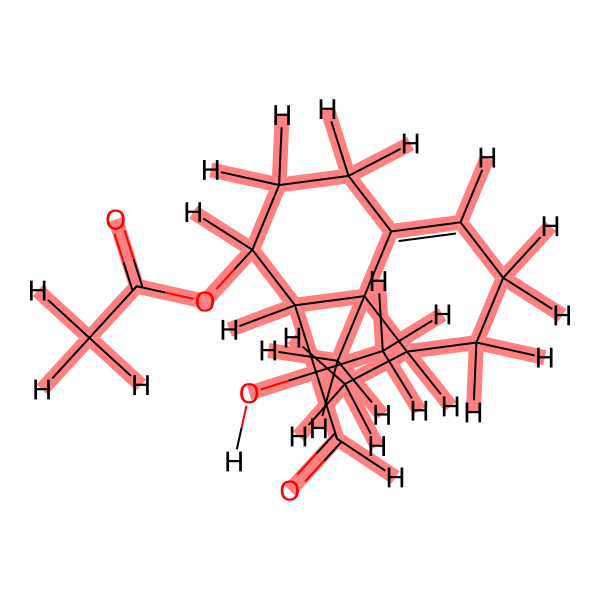

In [18]:
inference.inference_utils.show_retrieved_mol_with_highlighted_frags(smile, pred_FP, index_to_frag_mapping, fp_gen, ao)


In [21]:
NMR_type_indicator.device, model.device, inputs.device

(device(type='cpu'), device(type='cpu'), device(type='cpu'))




Kavaratamide A


_________________________________________________________
________retival #1, cosine similarity to prediction: 0.7968283891677856_________________
SMILES: CC(O)C1CC1
Name ['1-cyclopropylethanol']


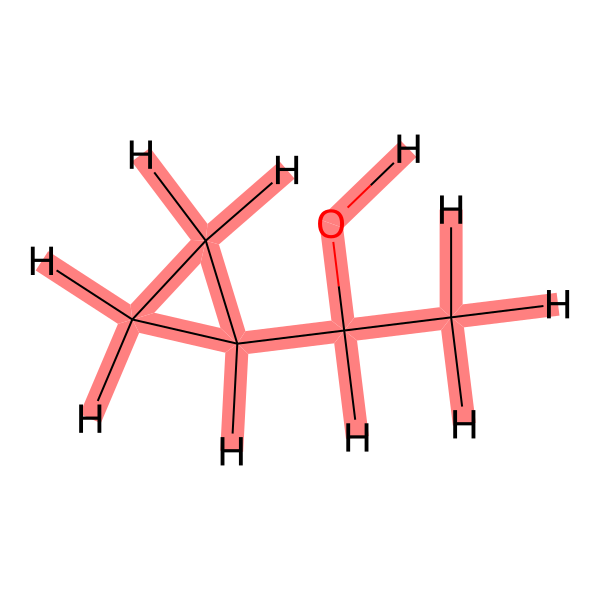

________retival #2, cosine similarity to prediction: 0.7968283891677856_________________
SMILES: CCC1CCC1O
Name 2-ethylcyclobutanol


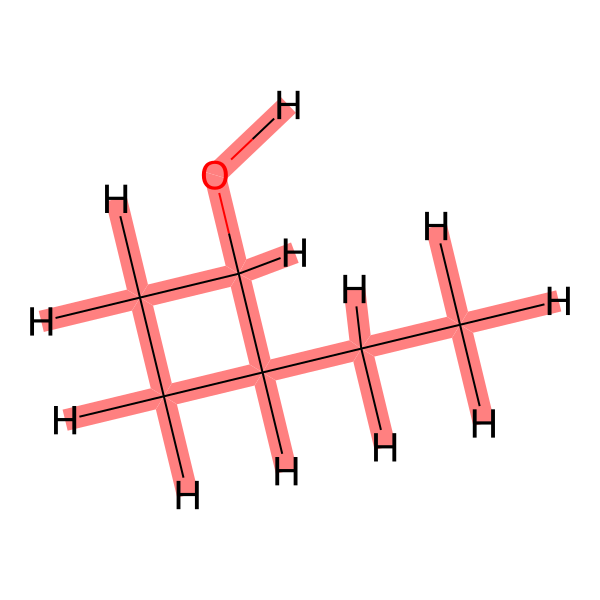

________retival #3, cosine similarity to prediction: 0.7395308017730713_________________
SMILES: CCC(C)O
Name (2~{R})-butan-2-ol


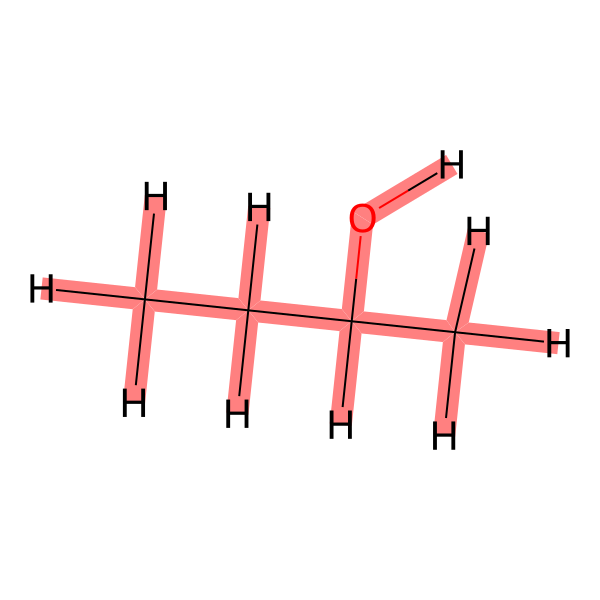

________retival #4, cosine similarity to prediction: 0.7395130395889282_________________
SMILES: CC(C)C(C)[CH]CC(C)C1[CH]CC2C3=[C]CC4C(C)C(O)C[CH]C4(C)C3C[CH]C21C
Name "(3~{S},4~{S},5~{R},10~{R},13~{R},17~{R})-4,10,13-trimethyl-17-[(1~{R},4~{S})-1,4,5-trimethylhexyl]-2,3,4,5,6,9,11,14,15,17-decahydrocyclopenta[a]phenanthren-3-ol"


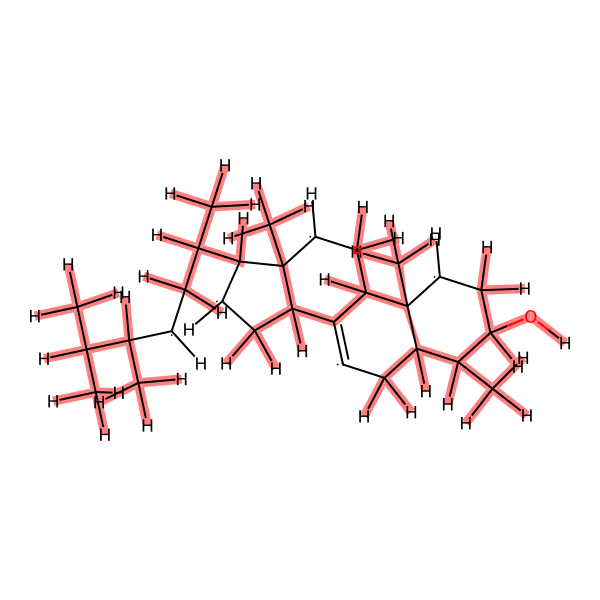

________retival #5, cosine similarity to prediction: 0.7395128011703491_________________
SMILES: OC(C1CC1)C1CC1
Name dicyclopropylmethanol


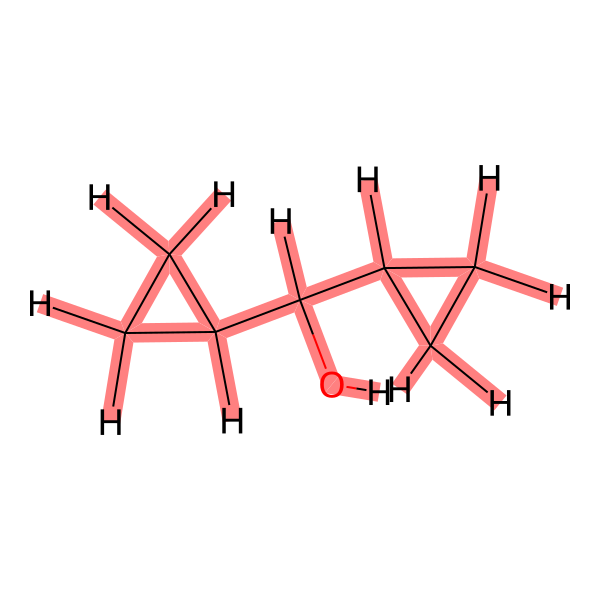

In [35]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = "swap"#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=5, mode = mode, ground_truth_FP=None,
                   fp_type = "DB_Specific_Radius",
                   index_to_frag_mapping=index_to_frag_mapping, 
                   fp_gen=fp_gen, ao=ao
                   )


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.5793654919)



________retival #1, cosine similarity to prediction: 0.7968283891677856_________________
SMILES: CC(O)C1CC1
Name ['1-cyclopropylethanol']


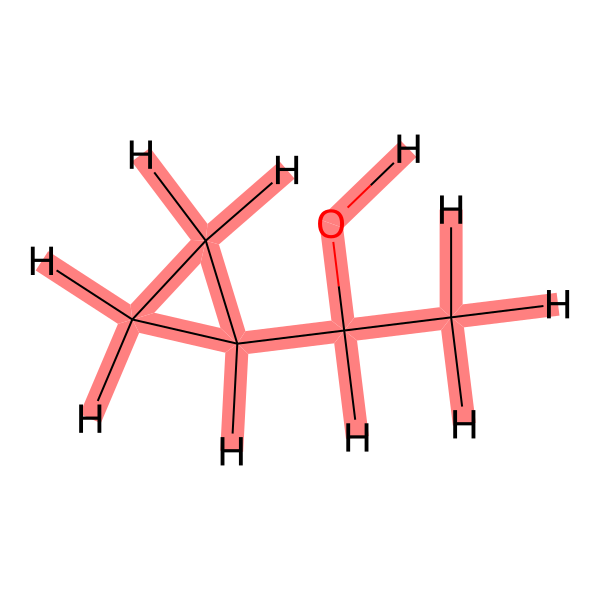

________retival #2, cosine similarity to prediction: 0.7968283891677856_________________
SMILES: CCC1CCC1O
Name 2-ethylcyclobutanol


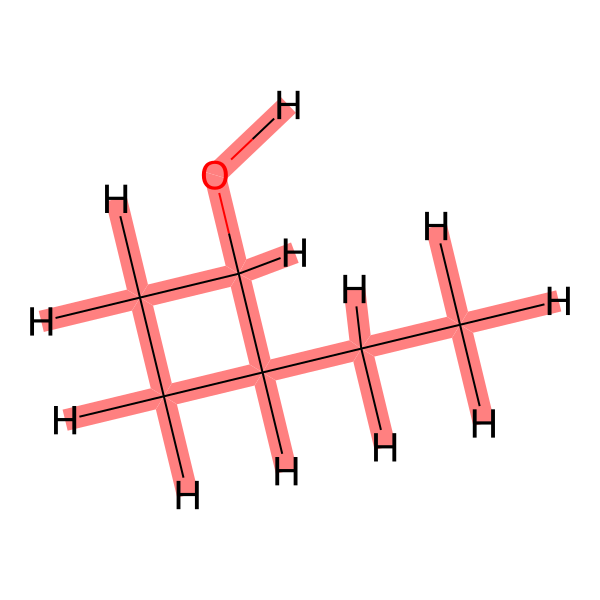

________retival #3, cosine similarity to prediction: 0.7395308017730713_________________
SMILES: CCC(C)O
Name (2~{R})-butan-2-ol


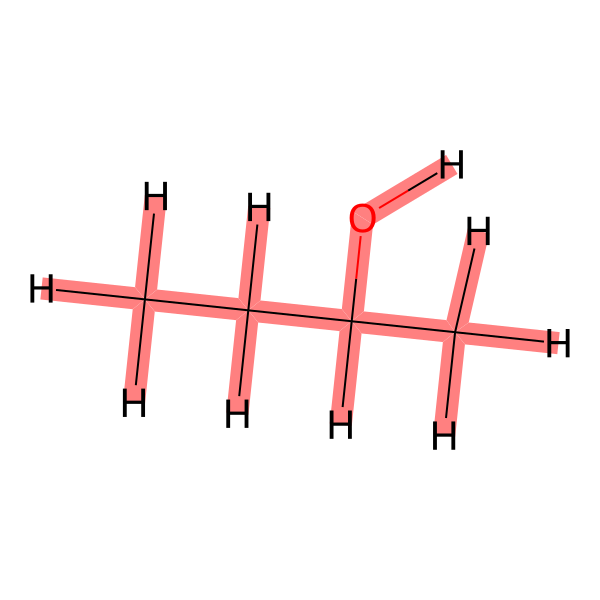

________retival #4, cosine similarity to prediction: 0.7395130395889282_________________
SMILES: CC(C)C(C)[CH]CC(C)C1[CH]CC2C3=[C]CC4C(C)C(O)C[CH]C4(C)C3C[CH]C21C
Name "(3~{S},4~{S},5~{R},10~{R},13~{R},17~{R})-4,10,13-trimethyl-17-[(1~{R},4~{S})-1,4,5-trimethylhexyl]-2,3,4,5,6,9,11,14,15,17-decahydrocyclopenta[a]phenanthren-3-ol"


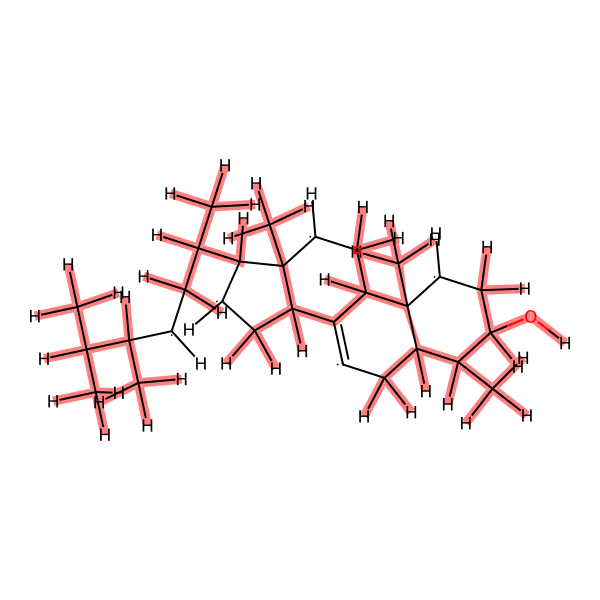

________retival #5, cosine similarity to prediction: 0.7395128011703491_________________
SMILES: OC(C1CC1)C1CC1
Name dicyclopropylmethanol


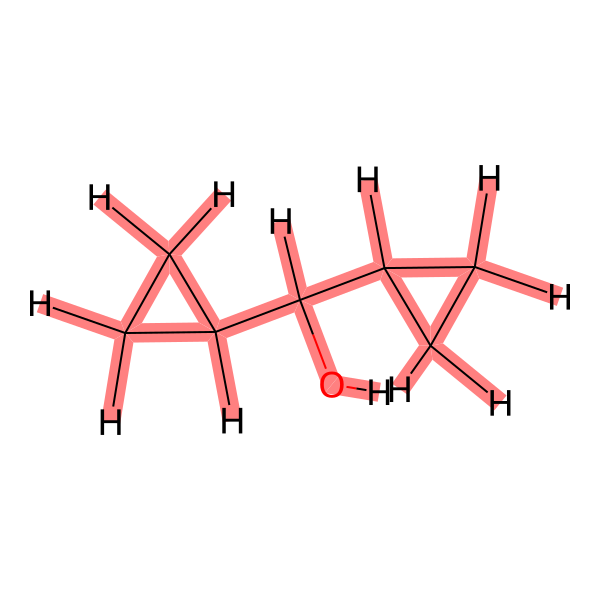

In [36]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = fp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=5, mode = 'flip_sign', ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "DB_Specific_Radius",
                   index_to_frag_mapping=index_to_frag_mapping, 
                   fp_gen=fp_gen, ao=ao
                   )


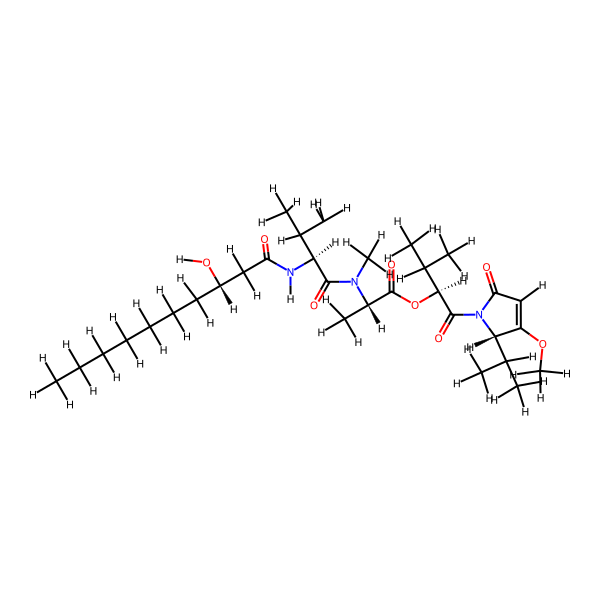

In [24]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
mol = Chem.AddHs(mol)
Draw.MolToImage(mol, size=(600, 600)).show()




new_compound_A


_________________________________________________________
________retival #1, cosine similarity to prediction: 0.6975723505020142_________________
SMILES: CC12CC(CO)C(C)(c3ccccc31)c1ccccc12
Name "[(15~{R})-1,8-dimethyl-15-tetracyclo[6.6.2.0^{2,7}.0^{9,14}]hexadeca-2,4,6,9,11,13-hexaenyl]methanol"


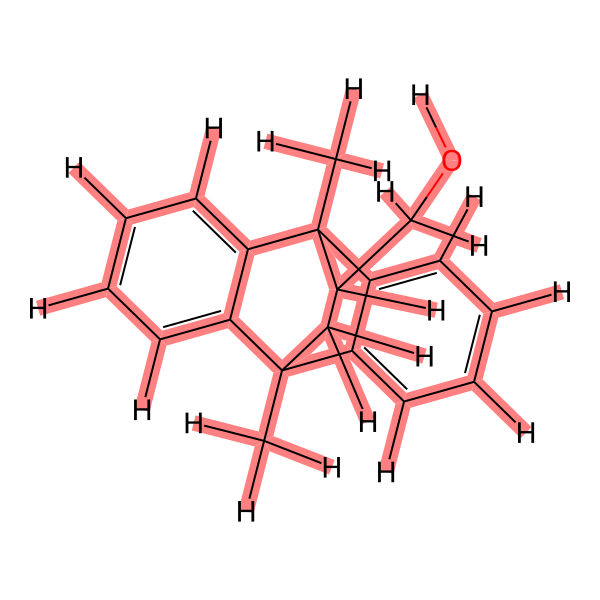

________retival #2, cosine similarity to prediction: 0.6808701753616333_________________
SMILES: CC(C)C12CN3CC(C(C)C)(CN(C1)C3c1ccccc1)C2O
Name "5,7-diisopropyl-2-phenyl-1,3-diazatricyclo[3.3.1.1^{3,7}]decan-6-ol"


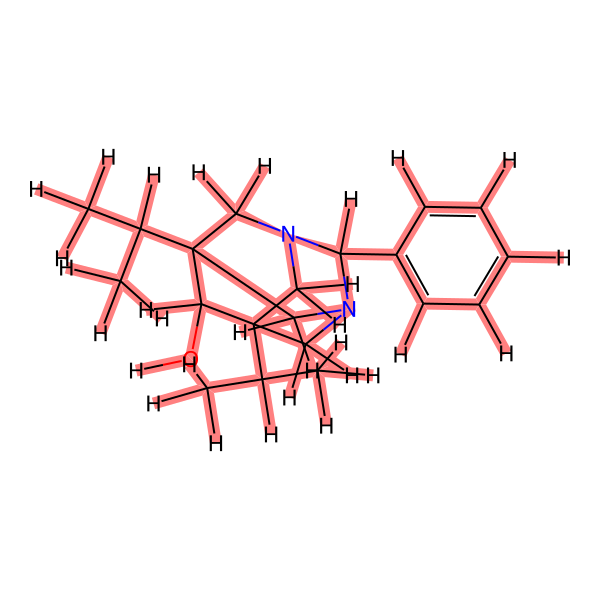

________retival #3, cosine similarity to prediction: 0.6695046424865723_________________
SMILES: CC1(C)C2CCC1(C)C(O)C2SCc1ccccc1
Name ['102250814']


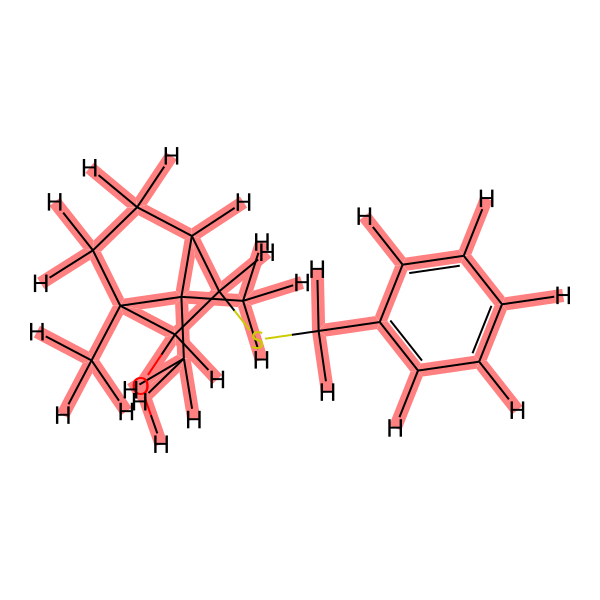

________retival #4, cosine similarity to prediction: 0.6663579344749451_________________
SMILES: CCC12CN3CC(CC)(CN(C1)C3c1ccc(O)cc1)C2O
Name "5,7-diethyl-2-(4-hydroxyphenyl)-1,3-diazatricyclo[3.3.1.1^{3,7}]decan-6-ol"


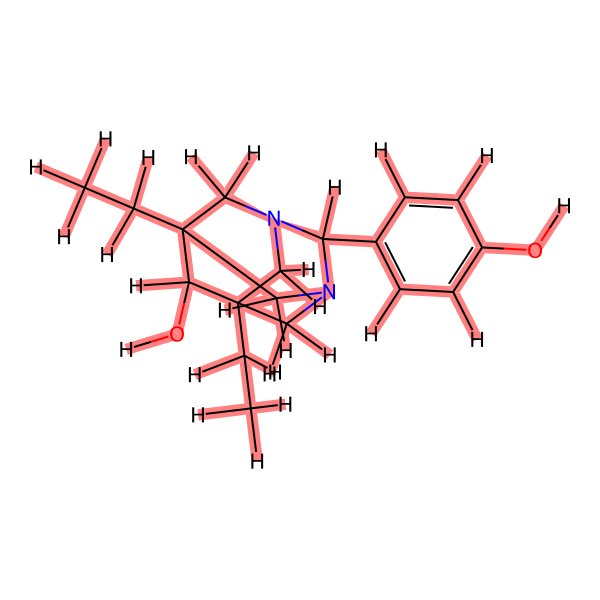

________retival #5, cosine similarity to prediction: 0.6651493310928345_________________
SMILES: OCC1CCC(c2ccc(O)c(O)c2)(c2ccc(O)c(O)c2)O1
Name "4-[(5~{S})-2-(3,4-dihydroxyphenyl)-5-(hydroxymethyl)tetrahydrofuran-2-yl]benzene-1,2-diol"


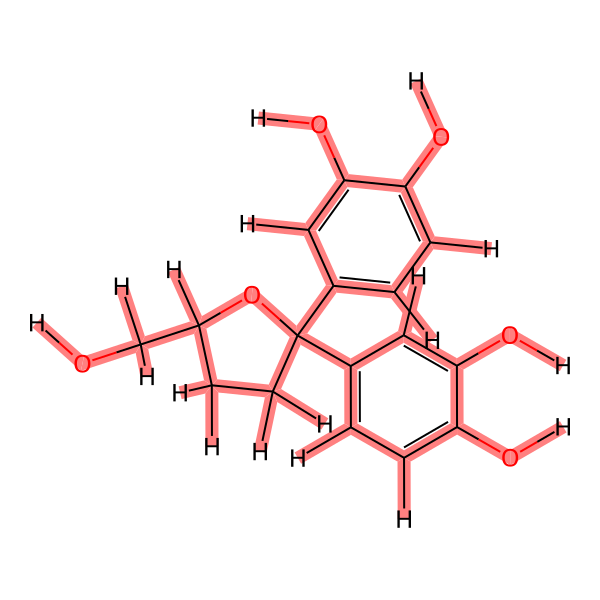

In [34]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
mode = "swap"#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=5, mode = mode, ground_truth_FP=None,
                   fp_type = "DB_Specific_Radius",
                   index_to_frag_mapping=index_to_frag_mapping, 
                   fp_gen=fp_gen, ao=ao
                   )


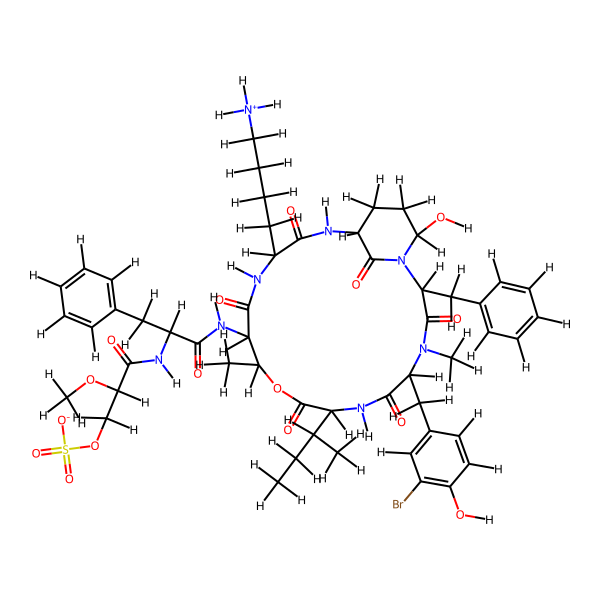

In [26]:
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
mol = Chem.MolFromSmiles(newCompoundA_SMILES)
mol = Chem.AddHs(mol)
Draw.MolToImage(mol, size=(600, 600)).show()